In [1]:
import pandas as pd
import gensim
from gensim.models import Word2Vec, KeyedVectors
import gzip 
import math
import itertools
from time import time
from tqdm import tqdm
import tqdm.notebook as tq
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import os
import vec_tools
import word_tools
import statistics
from nltk.corpus import stopwords
import random

# Create/load domains

In [2]:
lst_dir =  "G:/My Drive/KU/Thesis/data/domains/" 
domain_dic = {}

garg_lists = ["occupations1950.txt", "adjectives_appearance.txt",  'adjectives_appearance.txt',
 'adjectives_intelligencegeneral.txt', 'adjectives_otherization.txt', 'adjectives_princeton.txt',
 'adjectives_sensitive.txt', 'adjectives_williamsbest.csv', 'adjectives_williamsbest.txt',
 'personalitytraits_original.txt', 'occupations1950_professional.txt']

for dic in garg_lists:
    li = open(f"G:/My Drive/KU/Thesis/data/garg/{dic}", encoding="utf-8").readlines()
    domain_dic[dic[:-4]] = [el.strip() for el in li]

wiki_lists = ['music_genres','lit_genres','us_cities','uk_cities',
               'countries','hobbies','subcultures'] #sports
for lst in wiki_lists:
    domain_dic[lst] = word_tools.load_list(f"{lst_dir}/wiki/{lst}_wiki.txt")
    
manual_lists = [ 'virtues.txt', 'vices.txt', 'genres.txt', 'emotions.txt', 'housing.txt',
 'clothing.txt', 'white_trash.txt', 'old_rich.txt', 'new_rich.txt', 'u.txt', 'new_u.txt', 'non_u.txt',
 'refined.txt', 'sports.txt', 'unrefined.txt', 'art_movs.txt', 'Subcultures.txt', 'places-of-entertainment.txt',
                'vehicles.txt']
for dic in manual_lists:
    li = open(f"G:/My Drive/KU/Thesis/data/domains/{dic}").readlines()
    domain_dic[dic[:-4]] = [el.strip() for el in li]
domain_dic.keys()

domain_dic["goc_genres"] = ["hiphop", "rap", "bluegrass", "opera", "jazz", "techno", "punk"]
domain_dic["all_cult"] = {"Vehicles":domain_dic["vehicles"],"Housing":domain_dic["housing"], "Occupation": domain_dic["occupations1950"], "Clothing":domain_dic["clothing"], "Places of Entertainment":domain_dic["places-of-entertainment"], "Music":domain_dic["goc_genres"], "Sport":domain_dic["sports"]}
#"goc_genres", "art_movs", "hobbies", "genres", "emerging_traditional_genres", "housing"

In [3]:
groups =['Iso_occupations.xlsx','standard_occupations_uk_incomplete.xlsx','occupations_1950_categorised.xlsx','vices_virtues.xlsx','u_non_u.xlsx','old_rich_new_rich.xlsx','emerging_traditional_genres.xlsx', 'goc_culture_domains.xlsx']
os.chdir("G:/My Drive/KU/Thesis/data/domains/dicts/")
os.listdir()
for group in groups: 
    domain_dic[group[:-5]] = vec_tools.load_domain_dic(f"G:/My Drive/KU/Thesis/data/domains/dicts/{group}")
   

# Almighty iterator (now in vec_tools)

In [4]:
class AllDecsIterator():
    def __init__(self, coll, dims, kv, test=False):
        self.coll = coll
        self.dims = dims
        self.stereotypes = {}
        self.test=test
        self.kv = kv
        
    def iterate(self):
        self.input_dir = f"D:/google_ngrams/vectors/{coll}/"
        decades_dict = OrderedDict()
        if self.test == True:
            rng = 2
        else: 
            rng = 10
        for i in range(rng):
            decades_dict[str(1900+10*i)] = str(1900+10*i)+'_model'
        self.wvs = vec_tools.load_wvs(decades_dict, self.input_dir, kv=self.kv)
        self.ants = {dec : {} for dec, val in self.wvs.items()}
        self.projs = {dec : {} for dec, val in self.wvs.items()}
        self.dim_vecs = {dec : {} for dec, val in self.wvs.items()}
        self.angles = {dec : {} for dec, val in self.wvs.items()}
        self.norm_matrix = {dec : {} for dec, val in self.wvs.items()}
        self.stereotypes = {dec : {} for dec, val in self.wvs.items()}
        
        for dec, wv in self.wvs.items():
            matrix = wv.get_normed_vectors()
            self.norm_matrix[dec] = vec_tools.normify_matrix(matrix)

            for dim in self.dims:
                self.ants[dec][dim] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{dim}_antonyms_goc.csv", header = 0, names = ("pos_ant", "neg_ant"))
                self.ants[dec][dim] = self.ants[dec][dim].rename(columns= {"pos_ant":self.ants[dec][dim].iloc[0,0],"neg_ant":self.ants[dec][dim].iloc[0,1]})
                print(self.ants[dec][dim])
                self.dim_vecs[dec][dim] = vec_tools.create_dim_avg(wv, self.ants[dec][dim])
                self.projs[dec][dim] = vec_tools.proj_dim(self.dim_vecs[dec][dim], self.norm_matrix[dec])
               # print(dec, dim, self.projs[dec][dim])
            
            #Calculate angles between dimensions per decade
            self.angles[dec] = {dim : {} for dim in self.dims}
            for dim1 in self.dims:
                for dim2 in self.dims:
                    angle = vec_tools.vector_angle(self.dim_vecs[dec][dim1], self.dim_vecs[dec][dim2])
                    self.angles[dec][dim1][dim2] = angle
            self.angles[dec] = pd.DataFrame(self.angles[dec])
    
    def stability_through_time(self, n=50):
        '''Retuns dictionary of dictionaries that shows the difference the average of
        the distances between each stop word for each decade'''
        
        print("Calculating stability through time...")
        words = ["f_words", "rand_words"]
        w_lists = {}
        
        w_lists["f_words"] =  stopwords.words('english')
        self.vocab_size = self.norm_matrix["1900"].shape[0]
        rand_inds = [random.randint(0, self.vocab_size) for i in range(n)]
        rand_words = [self.wvs["1900"].index_to_key[ind] for ind in rand_inds]
        w_lists["rand_words"] = []
        for word in rand_words:
            for dec, wv in self.wvs.items():
                try:
                    vec = wv[word]
                except:
                    break
            w_lists["rand_words"].append(word)
        
        dists = {}
        avg_dists = {}
        diffs = {}
        for w_list in words:
            dists[w_list] = {}
            avg_dists[w_list] = {}
            for dec, wv in self.wvs.items():
                dists[w_list][dec] = {}
                for i, fword_1 in enumerate(w_lists[w_list]):
                    dists[w_list][dec][fword_1] = {}
                    for fword_2 in w_lists[w_list][i:]:
                        try:
                            wv_1, wv_2 = wv[fword_1], wv[fword_2]
                            dist = np.linalg.norm(wv_1 - wv_2)
                            dists[w_list][dec][fword_1][fword_2] = dist
                        except:
                            continue
                #avg_dists[dec] = np.mean(dists[dec].values)
            diffs[w_list] = {dec: {} for dec, wv in self.wvs.items()}
            for dec_1, wv in self.wvs.items():
                for dec_2, wv in self.wvs.items():
                    diffs[w_list][dec_1][dec_2] = []
                    for i, fword_1 in enumerate(w_lists[w_list]):
                        for fword_2 in w_lists[w_list][i:]:
                            try:
                                diffs[w_list][dec_1][dec_2].append(abs(dists[w_list][dec_2][fword_1][fword_2] - dists[w_list][dec_1][fword_1][fword_2]))
                            except:
                                continue
                    diffs[w_list][dec_1][dec_2] = np.mean(diffs[w_list][dec_1][dec_2])
        #df = pd.DataFrame()
        diffs["f_words"] = diffs["f_words"]["1900"]
        diffs["rand_words"] = diffs["rand_words"]["1900"]
        return pd.DataFrame(diffs) 
    
    def avg_distance(self, n=50): #e.g. self.norm_matrix["decade"]
        print("Calculating average distance...")
        self.dists = {dec:[] for dec, wv in self.wvs.items()}
        for dec, norm_matrix in self.norm_matrix.items():
            rand_inds = [random.randint(0, norm_matrix.shape[0]) for i in range(n)]
            for ind_1 in rand_inds:
                for ind_2 in rand_inds:
                    self.dists[dec].append(np.linalg.norm(norm_matrix[ind_1] - norm_matrix[ind_2]))
            self.dists[dec] = [el for el in self.dists[dec] if not pd.isna(el)]
            self.dists[dec] = statistics.mean(self.dists[dec])
        self.dists = pd.DataFrame(self.dists, index=["Mean distance"])
        return self.dists
             
    def stereotype_through_time(self, word, word_list=[], type="tag", select="a", selectn=10, topn= 100): #INCOMPLETE
        '''wvs is an ordered dict, domain_list is a list of words, type is type of tagging, 
        select is specifics of tag'''
        self.stereotypes[word] = {}
        if type == "tag":
            df = {}
            for decade, wv in self.wvs.items():
                df[decade] = {i: "" for i in range(selectn)}
                sims = vec_tools.most_similar_tag(word, wv, vec_tools.wn_tagger, topn=topn, selectn=selectn, select=select)
                for i,sim in enumerate(sims):  
                    df[decade][i] = sim
        elif type == None: 
            df= {}
            for decade, wv in self.wvs.items():
                df[decade] = {i: "" for i in range(selectn)}
                sims = vec_tools.most_similar_wlist(word, wv, word_list=False, topn=topn, selectn=selectn)
                for i,sim in enumerate(sims):  
                    df[decade][i] = sim[0]
        else:
            df= {}
            for decade, wv in self.wvs.items():
                df[decade] = {i: "" for i in range(selectn)}
                sims = vec_tools.most_similar_wlist(word, wv, word_list, topn=topn, selectn=selectn)
                for i,sim in enumerate(sims):  
                    df[decade][i] = sim[0]
        df = pd.DataFrame(df)
        self.stereotypes[word] = df
    
    def word_charts_through_time(self, domain, domain_dic, dim_1, dim_2, dom_type="word_list", title=False):
        '''dims = list of two strings which refer to dimensions to be projected on'''
        try:
            os.makedirs(f"G:/My Drive/KU/Thesis/Outputs/Graphs/{domain}_{dim_1}_{dim_2}")
        except Exception as e:
            pass
        #Get stats on projections to align output graphs with one another
        data_projs = {dim_1: [], dim_2: []}
        stats = ["min", "max", "mean", "median", "variance", "dev"]
        chart_vals = {stat : {dim: 0 for dim in [dim_1, dim_2]} for stat in stats}
                      
        if dom_type == "word_dict":
              #  print(domain_dic[domain])
            word_list = [word for cat in domain_dic[domain].keys() for word in domain_dic[domain][cat]]
        else:
            word_list = [word for word in domain_dic[domain]]
                     
        for dim in [dim_1, dim_2]:
            for dec, wv in self.wvs.items():
                for word in word_list: 
                    try:
                        ind = wv.get_index(word.lower())
                        proj = self.projs[dec][dim][ind]
                        data_projs[dim].append(proj)
                    except Exception as e:
                        pass
                #data_projs[dim][dec] = [val for val in data_projs[dim][dec] if np.isnan(val)==False] 
                #chart_vals["min"][dim][dec] = min(data_projs[dim][dec])
                #chart_vals["max"][dim][dec] = max(data_projs[dim][dec])
                #chart_vals["median"][dim][dec] = statistics.median(data_projs[dim][dec])
                #chart_vals["mean"][dim][dec] = statistics.mean(data_projs[dim][dec])
                #chart_vals["variance"][dim][dec] = np.var(data_projs[dim][dec])
            df = data_projs
            chart_vals["min"][dim] = min(df[dim])
            chart_vals["max"][dim] = max(df[dim])
            chart_vals["median"][dim] = statistics.median(df[dim])
            chart_vals["mean"][dim] = statistics.mean(df[dim])
            chart_vals["variance"][dim] = np.var(df[dim])
        #Generate a chart for each decade
        for dec, wv in self.wvs.items():
            if not title:
                try:
                    os.mkdirs(f"G:/My Drive/KU/Thesis/Outputs/Graphs/{domain}_{dim_1}_{dim_2}/")
                except:
                    pass
                fname = f"G:/My Drive/KU/Thesis/Outputs/Graphs/{domain}_{dim_1}_{dim_2}/{self.coll}_{dec}.png"
            dim1_label = self.ants[dec][dim_1].columns[1] + " <------ " + dim_1 + " ------> " + self.ants[dec][dim_1].columns[0]
            dim2_label = self.ants[dec][dim_2].columns[1] + " <------ " + dim_2 + " ------> " + self.ants[dec][dim_2].columns[0]
            if dom_type == "word_dict":
                vec_tools.chart_project_dict(proj_1=self.projs[dec][dim_1], 
                                    p1_label=dim1_label, 
                                    proj_2=self.projs[dec][dim_2], 
                                    p2_label=dim2_label,
                                    title=fname, 
                                    domain_dic=domain_dic[domain], 
                                    wv=wv, 
                                    show=False,
                                    dim_1_span=(chart_vals["min"][dim_1],chart_vals["max"][dim_1]), 
                                    dim_2_span= (chart_vals["min"][dim_2],chart_vals["max"][dim_2]))
                                 #  dim_1_span=(chart_vals["min"][dim_1]["overall"],chart_vals["max"][dim_1]["overall"]), 
                                  #                 dim_2_span= (chart_vals["min"][dim_2]["overall"],chart_vals["max"][dim_2]["overall"]))
          
            else:
                vec_tools.chart_project(proj_1=self.projs[dec][dim_1], 
                                        p1_label=dim1_label, 
                                        proj_2=self.projs[dec][dim_2], 
                                        p2_label=dim2_label,
                                        title=fname, 
                                        word_list=domain_dic[domain], 
                                        wv=wv, 
                                        show=False,
                                       dim_1_span=(chart_vals["min"][dim_1],chart_vals["max"]), 
                                                   dim_2_span= (chart_vals["min"][dim_2],chart_vals["max"][dim_2]))
    def chart_iterate(self, dims, doms, domain_dic, dom_type):
        for i, dim_1 in enumerate(dims):
            for dim_2 in dims_of_interest[i+1:]:
                for domain, word_list in domain_dic.items():
                    if domain not in doms:
                        continue
                    print(f"Charting domain {domain} against dims ({dim_1} x {dim_2})")
                    self.word_charts_through_time(domain=domain, domain_dic=domain_dic, dom_type=dom_type, dim_1=dim_1, dim_2=dim_2, title=False)
                # print(f"{fname} SAVED")


In [5]:
coll = "histwords_engall"#"gb_12_18_02"#
#input_dir = f"D:/google_ngrams/vectors/{coll}"
dims = ["affluence", "cultivation", "status", "gender", "race", "morality", "education", "employer"]
histwords_iter = vec_tools.AllDecsIterator(coll, dims, kv=True, test=False)
histwords_iter.iterate()
#dists = iterator.stability_through_time()
#iterator.avg_distance(n=50)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:161: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))
G:\My Drive\KU\Thesis\vec_tools.py:152: RuntimeWarning: invalid value encountered in arccos
  angle = np.arccos(dot)


## Charts through time

In [ ]:
dims_of_interest = ["affluence",  "cultivation" ,"status"]#"race",
#domains: 
groups_of_interest = ["Iso_occupations"]
doms_of_interest = ["goc_genres", "occupations1950", "clothing", "emotion", "housing", "sports", "popular-music-types", "emotions", "genres", "places of entertainment", "types-of-vehicle"]
histwords_iter.chart_iterate(dims = dims_of_interest, doms=groups_of_interest, domain_dic=domain_dic, dom_type="word_dict")
#for i, dim_1 in enumerate(dims_of_interest):
 #   for dim_2 in dims_of_interest[i+1:]:
  #      for domain, word_list in domain_dic.items():
   #         if domain not in groups_of_interest:
    #            continue
     #       print(f"Charting domain {domain} against dims ({dim_1} x {dim_2})")
      #      iterator.word_charts_through_time(domain=domain, dom_type="word_dict", dim_1=dim_1, dim_2=dim_2, title=False)
#coha_all_decs.word_charts_through_time(word_list=word_list, dim_1="affluence", dim_2="gender", title="occupations")

## Stereotype through time

In [ ]:
vec_tools.most_similar_tag(word, wv, vec_tools.wn_tagger, topn=100, selectn=selectn, select=select)

In [ ]:
word = "artist"
histwords_iter.stereotype_through_time(word, type="word_list", word_list=domain_dic["personalitytraits_original"], selectn=20, topn= 1000)
histwords_iter.stereotype_through_time(word, type="word_list", word_list=ns_words, selectn=30, topn= 10000)
histwords_iter.stereotypes[word]

In [ ]:
self = histwords_iter
word = "network"
wlist = domain_dic["Iso_occupations"]["Professional"]

wlist_projs  = {dim: {dec: [] for dec, wv in self.wvs.items()} for dim in self.dims}
word_projs = {dim: {} for dim in self.dims}
for dec, wv in self.wvs.items():
    for dim in self.dims:
        for word in wlist: 
            ind = wv.get_index(word.lower())
            proj = self.projs[dec][dim][ind]
            if pd.isna(proj):
                continue
            wlist_projs[dim][dec].append(proj)
           # print(dec, dim, word, proj)
        wlist_projs[dim][dec] = np.mean(wlist_projs[dim][dec])
        ind = wv.get_index(word.lower())
        proj = self.projs[dec][dim][ind]
        word_projs[dim][dec] = proj
df = pd.DataFrame(wlist_projs)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10,5)
df.plot.line()
df.unstack()

In [ ]:
word_list = domain_dic["occupations1950"][:7]
word_projs = {word: {} for word in word_list}
year_1, year_2 = ["1900", "1990"]
dim = "affluence"

for dec in [year_1, year_2]:
    for word in word_list:
        ind = self.wvs[dec].get_index(word.lower())
        proj = self.projs[dec][dim][ind]
        word_projs[word][dec] = proj
df = pd.DataFrame(word_projs)
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10,5)
df.plot.line()
#df.unstack()

In [ ]:
self.wvs

## Polar plots

In [ ]:
import plotly.express as px
px.line_polar(df, r="frequency", theta="direction", color="strength", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)

In [ ]:
n = pd.DataFrame(df.stack()).reset_index()
n.columns = ["Decade", "Dimension", "Projection"]
px.line_polar(n, r="Projection", theta="Dimension", color="Decade", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="ggplot2",)

# Silhouette for occupational clusters

In [137]:
import numpy as np
inds = []
wv = histwords_iter.wvs["1990"]
domain_d = domain_dic['Iso_occupations']
dim_1 = "affluence"
dim_2 = "cultivation"
inds = []
proj_1 = histwords_iter.projs["1990"][dim_1]
proj_2 = histwords_iter.projs["1990"][dim_2]
projs = {cat: {dim_1: {}, dim_2: {}} for cat in domain_d.keys()}
means = {cat: {dim_1: [], dim_2: []} for cat in domain_d.keys()}
means["General"] = {dim_1: [0], dim_2: [0]}
projs["General"] = {dim_1: [0], dim_2: [0]}
wl_projs = {cat: {} for cat in domain_d.keys()}

for cat, lst in domain_d.items():
    for word in lst:
        try:
            ind = wv.get_index(word.lower())
            inds.append(ind)
            val1, val2 = proj_1[ind], proj_2[ind]
            wl_projs[cat][word] = [val1, val2]

        except Exception as e:
            #print(e)
            continue
int_dists_dic = {cat: 0 for cat in domain_d.keys()}
ext_dists_dic = {cat: {} for cat in domain_d.keys()}
#print(wl_projs["Professional"])
for cat, lst in domain_d.items():
    int_dists = []
    ext_dists = {}
    for word in lst:
        for cat_2, lst_2 in domain_d.items():
            if cat_2 == cat:
                for other_word in lst_2:
                    dists = []
                    if word == other_word:
                        continue
                    else: 
                        try:
                            vec1 = np.array(wl_projs[cat][word])
                            vec2 = np.array(wl_projs[cat_2][other_word])
                        except Exception as e:
                            continue
                        dists.append(np.linalg.norm(vec1-vec2))
                    int_dists.append(np.mean(dists))
                int_dists_dic[cat] = np.mean(int_dists)
            else:
                ext_dists[cat_2] = []
                for other_word in lst_2:
                    dists = []
                    if word == other_word:
                        continue
                    else: 
                        try:
                            vec1 = np.array(wl_projs[cat][word])
                            vec2 = np.array(wl_projs[cat_2][other_word])
                        except Exception as e:
                            #print(e)
                            continue
                        dists.append(np.linalg.norm(vec1-vec2))
                    ext_dists[cat_2].append(np.mean(dists))
                ext_dists_dic[cat][cat_2] = np.mean(ext_dists[cat_2])

    
        

In [147]:
ratios = {}
pd.DataFrame(ext_dists_dic)
for cat in int_dists_dic.keys():
    try:
        ratio = int_dists_dic[cat]/np.mean([cat_2 for cat_2 in ext_dists[cat]])
        ratios[cat] = ratio
    except:
        pass

In [148]:
ratios

{'Managers': 0.39833358,
 'Professional': 1.1904631,
 'Technicians and associate professionals': 1.0670938,
 'Clerical support workers': 0.46321812,
 'Service and sales workers': 1.477423,
 'Skilled agricultural, forestry and fishery workers': 1.13135,
 'Craft and related trades ': nan,
 'Plant and machine operators, and assemblers': 1.2655936,
 'Elementary occupations': 1.0141782}

In [159]:
lst = [dic for cat in ext_dists_dic.keys() for dic in ext_dists_dic[cat].values() if dic == dic]
np.mean(lst)
lst

[0.122959025,
 0.08480968,
 0.10310464,
 0.11979273,
 0.14603971,
 0.17081052,
 0.06460522,
 0.06212934,
 0.12893496,
 0.07193986,
 0.13474593,
 0.09646833,
 0.050110538,
 0.087088935,
 0.12558587,
 0.09632858,
 0.076751664,
 0.09994828,
 0.10157256,
 0.08154378,
 0.07451691,
 0.105181836,
 0.09356865,
 0.051443435,
 0.11049927,
 0.16586639,
 0.10696248,
 0.12650824,
 0.14170219,
 0.13550292,
 0.12695058,
 0.10099214,
 0.17685279,
 0.15753826,
 0.116142675,
 0.14098167,
 0.07229453,
 0.07860463,
 0.15670171,
 0.13874623,
 0.15888092,
 0.1394513,
 0.09836297,
 0.14216249,
 0.10377126,
 0.0820984,
 0.14230148,
 0.122326754,
 0.022471385,
 0.111811,
 0.06506795,
 0.09357475,
 0.105334654,
 0.1259608,
 0.15192308,
 0.065012015,
 0.049331807,
 0.03696257,
 0.13656351,
 0.10368212,
 0.11171252,
 0.13408221,
 0.16475236,
 0.18773918,
 0.0780997,
 0.093321085,
 0.11329588,
 0.044352897,
 0.07680403,
 0.08340052,
 0.071625166,
 0.08796481,
 0.104348645]

# Dimension stability test

## Gathering words

In [9]:
self = histwords_iter
wv = histwords_iter.wvs["1900"]
l = 0
w = True


q = 0
top_words = pd.read_csv("G:/My Drive/KU/Thesis/data/unigram_freq.csv")
top_words = top_words["word"].to_list()[:10000]
input_words = top_words
#input_words = domain_dic["all_cult"]["Clothing"]



for dec, wv in self.wvs.items():
    ind2key = wv.index_to_key
    norm = self.norm_matrix[dec]
    if q == 0:
        words = []
        for word in input_words:
            try:
                vec = wv[word]
            except:
                continue
            if np.mean(vec) == 0:
                w = False
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                words.append(word)
            w = True
        words = set(words)
        q += 1
    elif q == "PREVIOUS VERSION":
        words = []
        for i, vec in enumerate(norm):
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                l += 1
                words.append(ind2key[i])
            w = True
        words = set(words)
        q = 1
    else: 
        words2 = []
        for i, vec in enumerate(norm):
            for e in vec:
                if e != e:
                    w = False
            if w == True:
                words2.append(ind2key[i])
            w = True
        words2 = set(words2)
        words = words.intersection(words2)
words = list(words)

## Projections of words 

In [10]:
def get_projection_corrs(self, input_words, save=None):
    for dec, wv in self.wvs.items():
        ind2key = wv.index_to_key
        norm = self.norm_matrix[dec]
        if q == 0:
            words = []
            for word in input_words:
                try:
                    vec = wv[word]
                except:
                    continue
                if np.mean(vec) == 0:
                    w = False
                for e in vec:
                    if e != e:
                        w = False
                if w == True:
                    words.append(word)
                w = True
            words = set(words)
            q += 1
        elif q == "PREVIOUS VERSION":
            words = []
            for i, vec in enumerate(norm):
                for e in vec:
                    if e != e:
                        w = False
                if w == True:
                    l += 1
                    words.append(ind2key[i])
                w = True
            words = set(words)
            q = 1
        else: 
            words2 = []
            for i, vec in enumerate(norm):
                for e in vec:
                    if e != e:
                        w = False
                if w == True:
                    words2.append(ind2key[i])
                w = True
            words2 = set(words2)
            words = words.intersection(words2)
    words = list(words)
    dics = {}
    self.inds = {}
    for dec, wv in self.wvs.items():
        dic = wv.key_to_index
        norm = self.norm_matrix[dec]
        self.inds[dec] = []
        for word in words:
            self.inds[dec].append(dic[word])

    self.proj_corrs = {}
    for dim in self.dims:
        self.proj_corrs[dim] = {}    
        for dec1, wv1 in self.wvs.items():
            self.proj_corrs[dim][dec1] = {}
            for dec2, wv2 in self.wvs.items():
                self.proj_corrs[dim][dec1][dec2] = {}
                projs1 = [self.projs[dec1][dim][ind] for ind in self.inds[dec1]]
                projs2 = [self.projs[dec2][dim][ind] for ind in self.inds[dec2]]
                self.proj_corrs[dim][dec1][dec2] = pearsonr(projs1, projs2)[0]
def plot_projection_corrs(self, n):
    fig, ax = plt.subplots(nrows=n//2, ncols=n%2, figsize = (15*(n//2),15*(n%2)))
    plt.style.use("ggplot")
    rdpu = cm.get_cmap('BuPu', n+2)
    colours = rdpu(range(n+2))

    parameters = {'figure.titlesize':20,#'axes.labelsize': 25,
                  'font.family':'Helvetica',

              'axes.titlesize': 25}
    plt.rcParams.update(parameters)


    for i,dim in enumerate(self.dims):
        done_decs = []
        j = 0
        for dec, wv in self.wvs.items():
            done_decs.append(dec)
            x = [deca for deca, val in self.proj_corrs[dim][dec].items() if deca not in done_decs]
            y = [val for deca, val in self.proj_corrs[dim][dec].items() if deca not in done_decs]
            ax[i//2, i%2].plot(x,y, color = colours[9-j], label = dec)
            ax[i//2, i%2].set_xlabel('Decade', fontsize = 20)
            ax[i//2, i%2].set_ylabel("Pearson's r", fontsize = 20)
            ax[i//2, i%2].tick_params(axis='both', which='major', labelsize=20)
            ax[i//2, i%2].set_ylim([0, 1])
            #ax[i//2, i%2].legend(shadow=True, fancybox=True)
          #  ax[i//2, i%2].tick_params(axis='both', which='minor', labelsize=8)
            handles, labels = ax[i//2, i%2].get_legend_handles_labels()
            #fig.legend(handles, labels, loc='lower right')

            tit = str(dim).title()
            ax[i//2, i%2].title.set_text(tit)
         #   ax[i//2, i%2]..titlesize
            j+=1
    if save:
        plt.savefig(f"G:/My Drive/KU/Thesis/outputs/graphs/{save}.jpg")

In [11]:
#ind = wv.get_index(word.lower())
from scipy.stats import pearsonr
self = histwords_iter
dics = {}
self.inds = {}
for dec, wv in self.wvs.items():
    dic = wv.key_to_index
    norm = self.norm_matrix[dec]
    self.inds[dec] = []
    for word in words:
        self.inds[dec].append(dic[word])

self.proj_corrs = {}
for dim in self.dims:
    self.proj_corrs[dim] = {}    
    for dec1, wv1 in self.wvs.items():
        self.proj_corrs[dim][dec1] = {}
        for dec2, wv2 in self.wvs.items():
            self.proj_corrs[dim][dec1][dec2] = {}
            projs1 = [self.projs[dec1][dim][ind] for ind in self.inds[dec1]]
            projs2 = [self.projs[dec2][dim][ind] for ind in self.inds[dec2]]
            self.proj_corrs[dim][dec1][dec2] = pearsonr(projs1, projs2)[0]
            
        
  
    
# 7 arrays of projections, a dictioanry of words to indices, then match up the proj values per word and correate

In [12]:
for i,dim in enumerate(self.dims):
     print(dim, self.proj_corrs[dim]["1900"]["1990"])

affluence 0.5011840330928771
cultivation 0.4629489043740331
status 0.6744908603319499
gender 0.3482880209572805
race 0.10390556886494295
morality 0.5955706964310848
education 0.2928270804203281
employer 0.4037406737744629


['affluence', 'cultivation', 'status', 'gender', 'race', 'morality', 'education', 'employer']


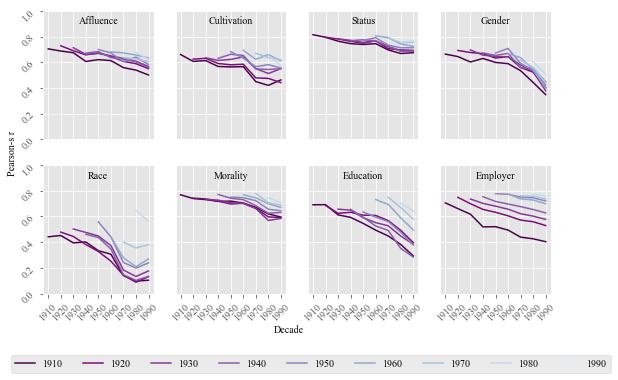

In [21]:
self = histwords_iter
from matplotlib import cm
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (9.094437525944375,5.2))
fig.text(0.5, 0.02, 'Decade', ha='center')
fig.text(0.07, 0.5, 'Pearson-s r', va='center', rotation='vertical')
plt.style.use("ggplot")
rdpu = cm.get_cmap('BuPu', 10)
colours = rdpu(range(10))

plt.rcParams["font.family"] = "Times New Roman"

dims = self.dims
print(dims)
for i,dim in enumerate(dims):
    if i == 7:
        fig.legend([1910+10*i for i in range(9)], loc='lower right', bbox_to_anchor=(1,-0.1), ncol=9, bbox_transform=fig.transFigure)
    done_decs = []
    j = 0
    for dec, wv in self.wvs.items():
        done_decs.append(dec)
        x = [deca for deca, val in self.proj_corrs[dim][dec].items() if deca not in done_decs]
        y = [val for deca, val in self.proj_corrs[dim][dec].items() if deca not in done_decs]
        ax[i//4, i%4].plot(x,y, color = colours[9-j], label = dec)
        
      
        ax[i//4, i%4].tick_params(axis='x', which='major', labelsize=10)
        ax[i//4, i%4].tick_params(axis='y', which='major', labelsize=10)
        ax[i//4, i%4].set_ylim([0, 1])
        ax[i//4, i%4].tick_params(labelrotation=45)
        if i//4 != 1:
            ax[i//4, i%4].tick_params(axis="x", colors ='white') 
        if i % 4 != 0:
            ax[i//4, i%4].tick_params(axis="y", colors ='white') 
        #ax[i//2, i%2].legend(shadow=True, fancybox=True)
      #  ax[i//2, i%2].tick_params(axis='both', which='minor', labelsize=8)
        #fig.legend(handles, labels, loc='lower right')
        
        tit = str(dim).title()
        ax[i//4, i%4].set_title(tit, y=0.85, fontsize=10)
     #   ax[i//2, i%2]..titlesize
        j+=1
plt.savefig("G:/My Drive/KU/Thesis/outputs/graphs/dimension_stability.jpg", dpi=400, bbox_inches = "tight")


# Dimension associations
Finding the most similar words to each cultural dimension pole in 1900 & 1990, and calculating their change in projection across the century

In [251]:
#end result: top_n most similar each dimension pole (pos/neg), their value @ 1900 and 1990
self = histwords_iter
topn = 10000
selectn = 5
similars = {}
similar_vals = {}
for dim in self.dims:
    similars[dim] = {}
    similar_vals[dim] = {}
    for dec in ["1900", "1990"]:
        similars[dim][dec] = []
        similar_vals[dim][dec] = []
        vec = self.dim_vecs[dec][dim]
        pos = self.ants[dec][dim].iloc[:,-2]
        neg = self.ants[dec][dim].iloc[:,-1]
        pos_list = []
        neg_list = []
        for i in range(len(pos)):
            try:
                n = self.wvs[dec][neg[i]]
                p = self.wvs[dec][pos[i]]
                pos_list.append(pos[i])
                neg_list.append(neg[i])
            except:
                continue
   #     print(dim, dec, self.wvs[dec].most_similar(positive = neg_list, topn=5))
        pos_sims = [word[0] for word in self.wvs[dec].most_similar(positive = pos_list, negative = neg_list, topn = topn)]
        neg_sims = [word[0] for word in self.wvs[dec].most_similar(positive = neg_list, negative = pos_list, topn = topn)]
        #similars[dim][dec]["positive"] = pos_sims
       # similars[dim][dec]["negative"] = neg_sims
        similars[dim][dec] = pos_sims[:selectn] + neg_sims[:selectn]
     #   print(dim, dec, pos_list, neg_list, similars[dim][dec] )
        s = 0
        for word in similars[dim][dec]:
            if s > selectn-1:
                break
            point = []
            for deca in ["1900","1990"]:
               # print(word, self.wvs[deca].n_similarity([word], pos_list))
                point.append(self.wvs[deca].n_similarity([word], pos_list))
            if point[0] == 0 or point[1] == 0:
               # print(dim, dec, word)
                continue
            similar_vals[dim][dec].append(point)
            s += 1
        
    

# Individual lifestyle domain GoC correlations

In [306]:
def corr_survey(self, model, groups):
        survey = pd.read_csv("G:/My Drive/KU/Thesis/data/survey_data/survey_means_weighted.csv")
        survey = survey.rename(columns= {"Unnamed: 0": "words"})
        survey = survey.set_index("words")
        cats =  ["race", "gender", "affluence"]
        
        ant_pairs = {}
        vals = {}
        projs = {}
        dims = {}
        embed = self.models[model]
        for group, items in groups.items():
            items = [item.lower() for item in items]
            vals[group] = {}
            for cat in cats:
                ant_pairs[cat] = pd.read_csv(f"G:/My Drive/KU/Thesis/data/word_pairs/{cat}_antonyms_goc.csv", header = None, names = ("pos_ant", "neg_ant"))
                ant_pairs[cat] = ant_pairs[cat].rename(columns= {"pos_ant":ant_pairs[cat].iloc[0,0],"neg_ant":ant_pairs[cat].iloc[0,1]})
                #prepare dictionaries for survey & projection values
                vals[group][cat + "_survey"] = {}
                vals[group][cat + "_proj"] = {}
                #calculate dimensions from antonym pairs
                dims[cat] = vec_tools.create_dim_avg(embed, ant_pairs[cat])
                #project embeddings onto dimension
                projs[cat] = self.proj_dim(model, dims[cat])
                #iterate through words
                not_in_vocab = []
                for row in survey.iterrows():
                    word = row[0].lower()
                    if word not in items:
                       # print(word, items)
                        continue
                    try:
                        #print(word)
                        #retrieve index in embeddings
                        ind = embed.get_index(word)
                        #retrieve projected value using index
                        val = projs[cat][ind]
                        #add all to DF
                        vals[group][cat + "_survey"][word] = row[1][cat + "_mean"]
                        vals[group][cat + "_proj"][word] = val
                    except Exception as e:
                        not_in_vocab.append(word)

          #  print(f"{not_in_vocab} not in embeddings vocab!")
        self.vals = vals#pd.DataFrame(vals)
        corrs = {group: {} for group in groups.keys()}
        print(vals)
        for group, items in groups.items():
            for cat in ["race", "gender", "affluence"]:
                #print(self.vals[group][cat + "_survey"], self.vals[group][cat + "_proj"])
                corrs[group][cat + "_survey_corr"] = pearsonr(list(self.vals[group][cat + "_survey"].values()), list(self.vals[group][cat + "_proj"].values()))    
               # corrs[cat + "_survey_corr"] = self.vals[[cat + "_survey", cat + "_proj"]].corr(method="pearson").iloc[0,1]
        return corrs
coll = "histwords_engall"
decade_files = [str(1900+10*i)+'_model' for i in range(10)]
eval_iter = vec_tools.EvalEmbeddings(dir = f"D:/google_ngrams/Vectors/{coll}/", files = decade_files, kv=True, dl=False)
eval_iter.load_wv(decade_files[-1])
#print(eval_iter.corr_census(decade_files[-1]))
corr_survey(eval_iter, decade_files[-1], domain_dic["goc_culture_domains"])

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:624: RuntimeWarning: invalid value encountered in true_divide
  return self.vectors / self.norms[..., np.newaxis]
G:\My Drive\KU\Thesis\vec_tools.py:156: RuntimeWarning: invalid value encountered in true_divide
  return vec/(np.sqrt(np.nansum(np.square(vec))))


{'Occupations': {'race_survey': {'hairdresser': 50.86118, 'lawyer': 35.66758, 'doctor': 37.82003, 'plumber': 39.27434, 'scientist': 32.74435, 'engineer': 32.92745, 'banker': 32.65704, 'nanny': 41.04066, 'carpenter': 42.08532, 'journalist': 39.90278, 'nurse': 43.68505}, 'race_proj': {'hairdresser': 0.070591584, 'lawyer': -0.0779458, 'doctor': 0.042965513, 'plumber': 0.05737286, 'scientist': -0.14644775, 'engineer': -0.09468469, 'banker': -0.05657224, 'nanny': 0.03622751, 'carpenter': 0.021289663, 'journalist': -0.14413749, 'nurse': -0.09299795}, 'gender_survey': {'hairdresser': 20.6902, 'lawyer': 61.77906, 'doctor': 60.06721, 'plumber': 80.25067, 'scientist': 61.87003, 'engineer': 69.79498, 'banker': 59.9074, 'nanny': 17.65112, 'carpenter': 80.9367, 'journalist': 47.79544, 'nurse': 26.29599}, 'gender_proj': {'hairdresser': 0.12751889, 'lawyer': 0.10730245, 'doctor': -0.03549278, 'plumber': 0.03289957, 'scientist': 0.05337469, 'engineer': 0.14826168, 'banker': 0.028463397, 'nanny': -0.01

{'Occupations': {'race_survey_corr': (0.544162270493768, 0.08352819710506733),
  'gender_survey_corr': (0.3488782673616875, 0.29300407890874536),
  'affluence_survey_corr': (0.10986557881846865, 0.7477795357055855)},
 'Clothing': {'race_survey_corr': (0.08063172585474714, 0.824760375859423),
  'gender_survey_corr': (0.6586505658896284, 0.03835945683596249),
  'affluence_survey_corr': (0.2596915212867243, 0.46871030076675635)},
 'Sports': {'race_survey_corr': (-0.13797113506799163, 0.7233481583077811),
  'gender_survey_corr': (-0.08468865673353053, 0.8285015165326973),
  'affluence_survey_corr': (-0.11429302512422897, 0.7696838771365931)},
 'Music Genres': {'race_survey_corr': (-0.5637014761234259,
   0.24400849431755847),
  'gender_survey_corr': (0.5852844507371021, 0.22232022663658643),
  'affluence_survey_corr': (0.9440859444592907, 0.004602168073106391)},
 'Vehicles': {'race_survey_corr': (0.4311938588247922, 0.5688061411752078),
  'gender_survey_corr': (-0.05124460065375383, 0.9487

In [324]:
ext = pd.read_csv("G:/My Drive/KU/Thesis/outputs/evals/evals_external_models.csv",header=0, index_col = 0).round(2)

print(df.to_latex("external_mods_eval.tex"))
df.columns = ['Fasttext Wiki News 300', 'GloVe Twitter 100',
       'GloVe Twitter 200', 'GloVe Twitter 25', 'GloVe Twitter 50',
       'GloVe Wiki 100', 'GloVe Wiki 200',
       'GloVe Wiki 300', 'GloVe Wiki 50',
       'Word2Vec 300']
df

None


,Fasttext Wiki News 300,GloVe Twitter 100,GloVe Twitter 200,GloVe Twitter 25,GloVe Twitter 50,GloVe Wiki 100,GloVe Wiki 200,GloVe Wiki 300,GloVe Wiki 50,Word2Vec 300
analogy_score,0.88,0.46,0.57,0.13,0.29,0.63,0.70,0.72,0.46,0.74
word_pair_pearson,0.61,0.52,0.53,0.36,0.47,0.55,0.58,0.60,0.51,0.62
word_pair_pearson_p_value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
word_pair_spearman,0.60,0.51,0.52,0.36,0.46,0.53,0.58,0.61,0.50,0.66
word_pair_spearman_p_value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
race_survey_corr,-0.56,-0.35,-0.32,-0.09,-0.23,-0.10,-0.38,-0.43,-0.04,-0.52
gender_survey_corr,0.88,0.77,0.83,0.40,0.62,0.79,0.87,0.86,0.73,0.80
affluence_survey_corr,0.49,0.14,0.30,0.04,0.06,0.28,0.52,0.55,0.38,0.49


In [ ]:
import scipy.stats as st
#data = list of data points
st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

In [244]:
self.wvs["1900"].most_similar(positive=self.ants["1900"]["affluence"].iloc[:,-2])

KeyError: "Key 'classy' not present"

In [250]:
similars
similar_vals = {}
for dim in self.dims:
    similar_vals[dim] = {}
    for dec in ["1900", "1990"]:
        similar_vals[dim][dec] = []